In [1]:
# Remove warnings
import warnings

warnings.filterwarnings('ignore')

# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

# Linear algrebra
import numpy as np
import pywt
# ML and Metrics module
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Data APIs
import yfinance as yf
from pytrends.request import TrendReq

# Technical indicators
from ta.momentum import rsi, stochrsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import ease_of_movement
from scipy.signal import savgol_filter, convolve, lfilter


from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope

Loading BokehJS ...

# Load the data

In [2]:
SYMBOL= 'BTC'
df = loadFromDB(SYMBOL,'1h')
df = computeLaggingLinearRegression(df,window=10,filter_ceof=True, derivative=True,filter_method='savgol')
df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff,High_Low_diff,...,Stoch_RSI,Vortex,Bollinger_low,Bollinger_high,ADX,ATR,CCI,OVB,OVB_EMA200,EVM
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-09 20:00:00,9731.15,9765.00,9713.80,9742.31,1615.257105,1591732800,0.000477,0.001604,0.000642,51.20,...,1.000000,0.040084,9739.789617,9661.683383,14.861048,46.588421,155.283055,-12815.529544,49.661143,8.296883e+07
2020-06-09 21:00:00,9742.30,9825.00,9740.79,9809.99,2803.283893,1591736400,0.000336,0.001780,0.000617,84.21,...,1.000000,0.194256,9767.850998,9644.773002,15.463252,50.350579,260.475351,-10012.245651,-50.457333,1.306580e+08
2020-06-09 22:00:00,9810.00,9829.00,9694.00,9771.82,2626.565554,1591740000,0.001836,0.001913,0.000566,135.00,...,0.620537,0.131617,9777.674462,9642.478538,14.739042,58.815521,138.773938,-12638.811205,-175.714585,-1.099658e+08
2020-06-09 23:00:00,9771.98,9800.00,9736.22,9772.43,1510.920739,1591743600,0.002446,0.001973,0.000369,63.78,...,0.602455,0.182360,9785.939321,9643.534679,14.066561,59.311969,121.947056,-11127.890466,-284.691460,2.790258e+07
2020-06-10 00:00:00,9772.44,9799.03,9753.21,9774.97,1643.818450,1591747200,0.002633,0.001980,0.000201,45.82,...,0.536664,0.213167,9792.925844,9646.752156,13.442115,57.962772,111.389082,-9484.072016,-376.227585,2.232717e+07


# Drawing Lines

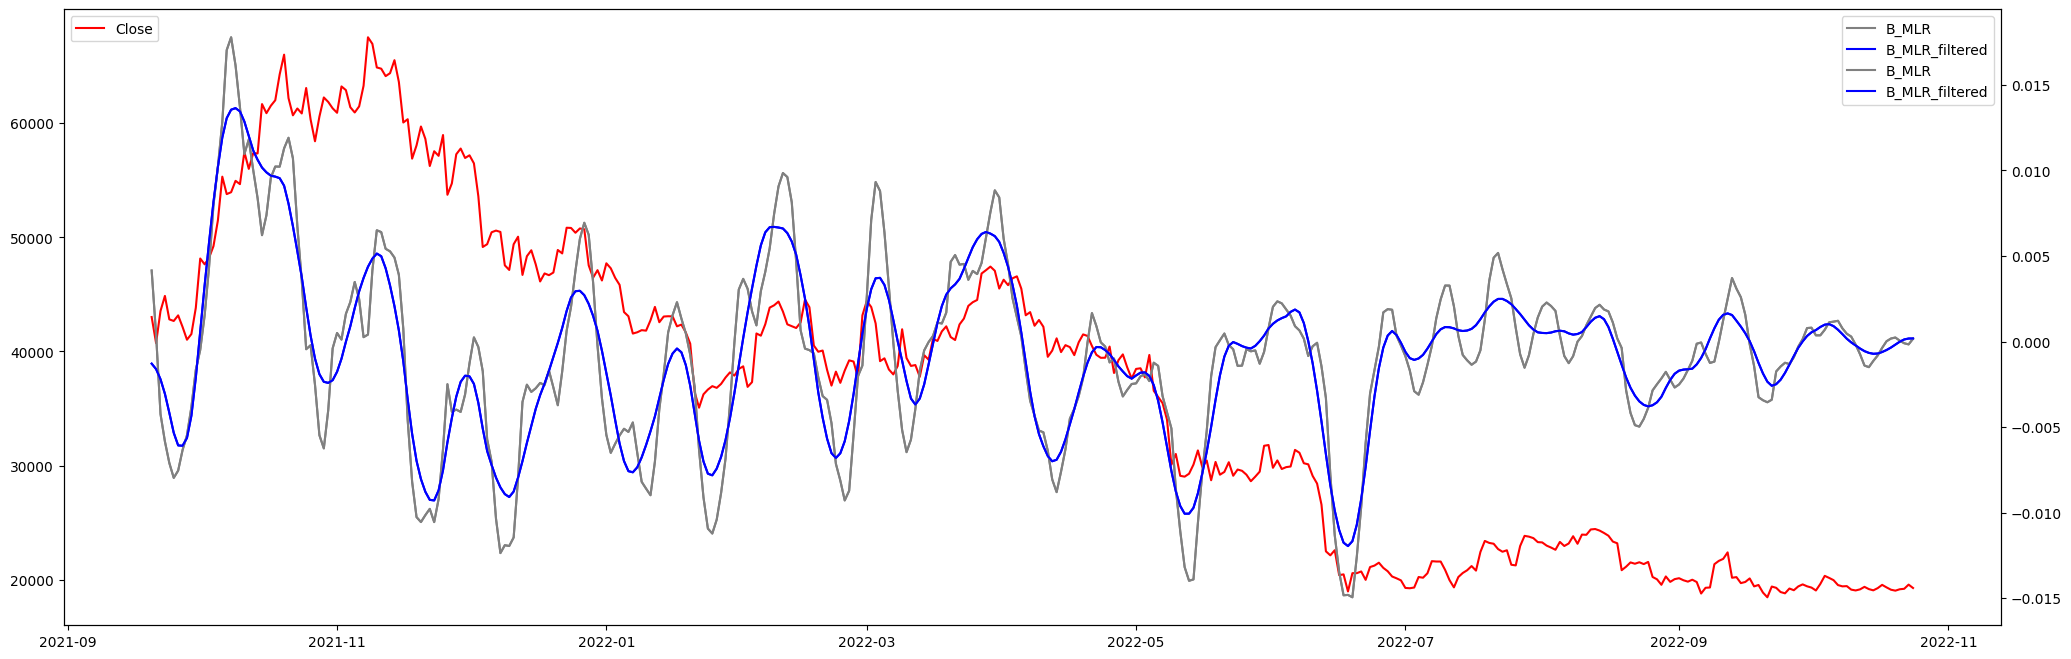

In [11]:
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_right = ax_left.twinx()

ax_left.plot(df.Close[-400:], color='red',label='Close')
ax_right.plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right.plot(df.B_MLR_coefs_filtered[-400:], color='blue',label='B_MLR_filtered')
ax_left.legend(loc="upper left")
ax_right.plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right.plot(df.B_MLR_coefs_filtered[-400:], color='blue',label='B_MLR_filtered')
ax_right.legend(loc="upper right")


# Creating a strategy

Period : [2020-12-30 00:00:00] -> [2022-10-24 00:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 4063.44 $
Performance vs US Dollar : 306.34 %
Buy and Hold Performence : -33.25 %
Performance vs Buy and Hold : -1021.29 %
Best trade : +46.09 %, the 2021-02-13 00:00:00
Worst trade : -9.58 %, the 2021-09-22 00:00:00
Worst drawBack : -10.0 %
Total fees :  130.86 $

----- Trades Informations -----
Total trades on period : 32
Number of positive trades : 21
Number of negative trades :  11
Trades win rate ratio : 65.62 %
Average trades performance : 5.15 %
Average positive trades : 9.49 %
Median positive trades : 3.82 %
Average negative trades : -3.13 %
Median negative trades : -1.73 %

----- Plot -----


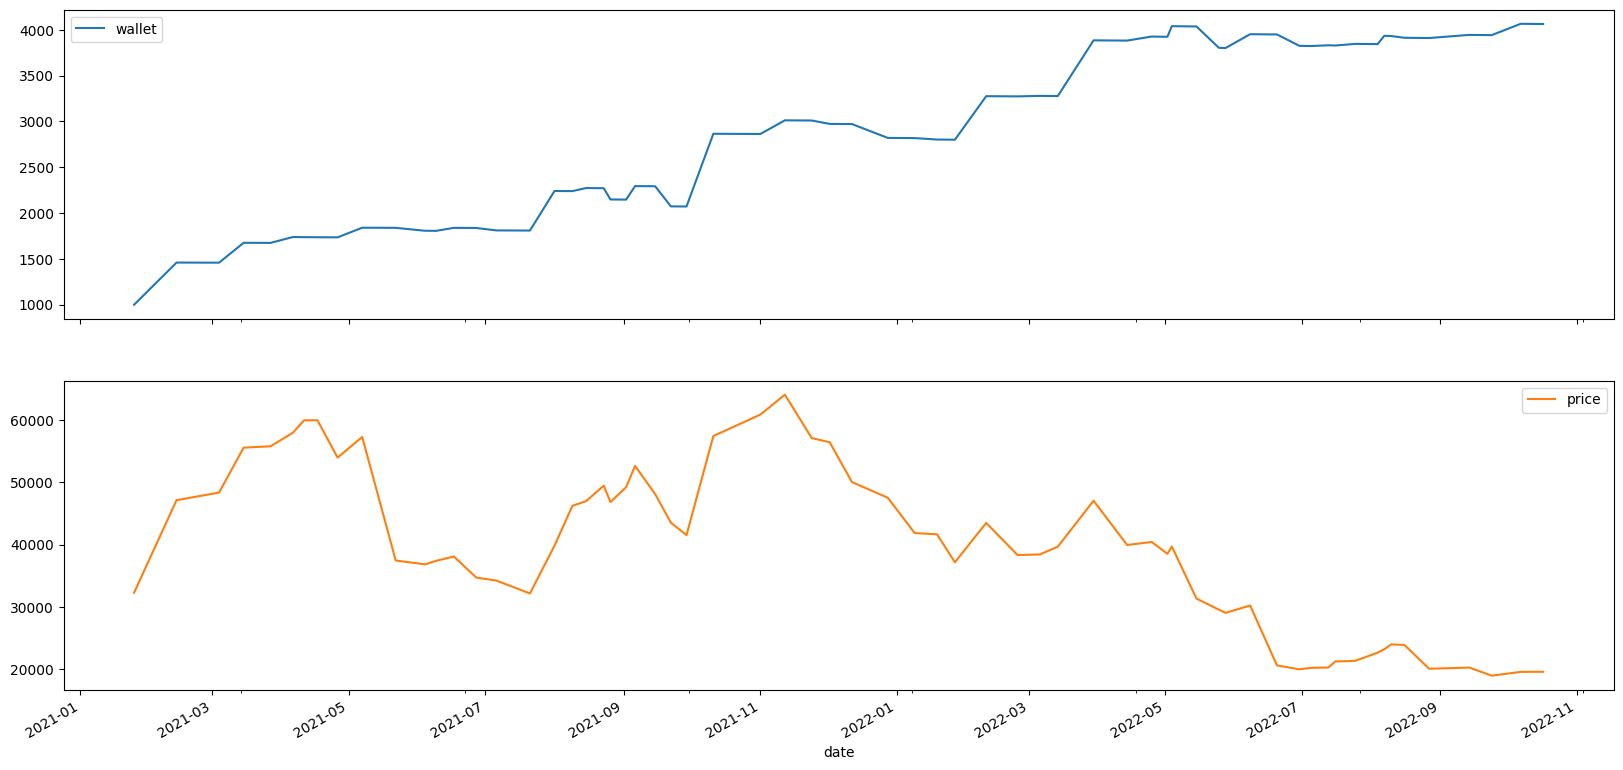

In [12]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff<0 and row.B_MLR_coefs_filtered_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff>0 and row.B_MLR_coefs_filtered_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# ML classify trade

In [3]:
df['Prev_B_MLR_coefs_filtered_diff'] = df.B_MLR_coefs_filtered_diff.shift(1)
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff,High_Low_diff,...,Vortex,Bollinger_low,Bollinger_high,ADX,ATR,CCI,OVB,OVB_EMA200,EVM,Prev_B_MLR_coefs_filtered_diff
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-09 21:00:00,9742.30,9825.00,9740.79,9809.99,2803.283893,1591736400,0.000336,0.001780,0.000617,84.21,...,0.194256,9767.850998,9644.773002,15.463252,50.350579,260.475351,-10012.245651,-50.457333,1.306580e+08,0.000642
2020-06-09 22:00:00,9810.00,9829.00,9694.00,9771.82,2626.565554,1591740000,0.001836,0.001913,0.000566,135.00,...,0.131617,9777.674462,9642.478538,14.739042,58.815521,138.773938,-12638.811205,-175.714585,-1.099658e+08,0.000617
2020-06-09 23:00:00,9771.98,9800.00,9736.22,9772.43,1510.920739,1591743600,0.002446,0.001973,0.000369,63.78,...,0.182360,9785.939321,9643.534679,14.066561,59.311969,121.947056,-11127.890466,-284.691460,2.790258e+07,0.000566
2020-06-10 00:00:00,9772.44,9799.03,9753.21,9774.97,1643.818450,1591747200,0.002633,0.001980,0.000201,45.82,...,0.213167,9792.925844,9646.752156,13.442115,57.962772,111.389082,-9484.072016,-376.227585,2.232717e+07,0.000369
2020-06-10 01:00:00,9774.97,9810.00,9774.97,9788.51,1386.033719,1591750800,0.002771,0.001926,0.000013,35.03,...,0.226028,9802.492588,9646.354412,13.139046,55.669495,119.788589,-8098.038297,-453.061522,4.136017e+07,0.000201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24 03:00:00,19414.97,19435.52,19342.33,19391.97,10196.903960,1666580400,-0.000604,0.002722,-0.006741,93.19,...,0.243098,19670.663726,19021.632274,29.973290,98.766085,-18.476334,64494.234679,132135.691640,-4.134506e+07,-0.005079
2022-10-24 04:00:00,19391.97,19392.41,19260.00,19336.06,10574.789880,1666584000,-0.002542,-0.000084,-0.007836,132.41,...,0.162232,19669.732738,19037.760262,27.979084,102.130476,-69.703963,53919.444799,131357.420527,-7.853352e+07,-0.006741
2022-10-24 05:00:00,19336.06,19355.70,19292.65,19336.43,7984.151790,1666587600,-0.005752,-0.002803,-0.008297,63.05,...,0.141353,19667.827436,19054.895564,26.127322,98.222429,-86.575299,61903.596589,130666.337702,-1.603069e+06,-0.007836


In [4]:
def process_trade(row)->int:
    if row['Prev_B_MLR_coefs_filtered_diff']<0 and row['B_MLR_coefs_filtered_diff']>0:
        return 1
    elif row['Prev_B_MLR_coefs_filtered_diff']>0 and row['B_MLR_coefs_filtered_diff']<0:
        return 1
    else:
        return 0

df['Trade'] = df.apply(process_trade,axis=1)
df_copy = df.copy()

df_copy.drop(columns=['Timestamp','B_MLR_coefs_filtered','B_MLR_coefs_filtered_diff','Prev_B_MLR_coefs_filtered_diff'],inplace=True)
df_copy = addIndicators(df_copy)
df_copy = computeRSI_VWAP(df_copy)
df_copy = computeTrixIndicator(df_copy, col='Close')
df_copy['Last_hour_Trade'] = df_copy['Trade'].shift(1)
df_copy.dropna(inplace=True)
df_copy

,Open,High,Low,Close,Volume,B_MLR_coefs,High_Low_diff,EMA20,EMA50,EMA100,...,ATR,CCI,OVB,OVB_EMA200,EVM,Trade,RSI_VWAP,Trix,Trix_histo,Last_hour_Trade
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-21 02:00:00,9374.67,9400.00,9361.57,9370.00,1494.943806,0.003513,38.43,9329.181073,9335.067702,9360.463032,...,41.283013,105.880338,18838.025937,13224.732004,3.453689e+07,0,30.994775,9309.556837,0.047041,0.0
2020-06-21 03:00:00,9370.00,9378.67,9360.37,9371.78,558.967588,0.003088,18.30,9333.238114,9336.507400,9360.687131,...,38.984711,79.369066,19396.993525,13286.147541,-3.688040e+07,0,33.923694,9313.347691,0.049541,0.0
2020-06-21 04:00:00,9371.82,9380.00,9367.72,9370.92,632.133350,0.002449,12.28,9336.826865,9337.856913,9360.889762,...,36.314240,73.371436,18764.860175,13340.662095,8.431006e+06,0,37.221318,9317.456758,0.050026,0.0
2020-06-21 05:00:00,9370.99,9395.61,9370.60,9388.02,829.109268,0.002205,25.01,9341.702401,9339.824093,9361.426994,...,35.183816,84.712868,19593.969443,13402.884058,2.788745e+07,1,40.744134,9321.865911,0.050084,0.0
2020-06-21 06:00:00,9388.01,9422.00,9369.23,9370.87,1601.634646,0.001543,52.77,9344.480268,9341.041580,9361.613984,...,36.942435,83.462552,17992.334797,13448.550235,4.121743e+07,0,50.974613,9326.362190,0.047710,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24 03:00:00,19414.97,19435.52,19342.33,19391.97,10196.903960,-0.000604,93.19,19378.197625,19280.460556,19236.933185,...,98.766085,-18.476334,74506.480330,142147.937291,-4.134506e+07,0,89.607513,19339.709687,0.050067,0.0
2022-10-24 04:00:00,19391.97,19392.41,19260.00,19336.06,10574.789880,-0.002542,132.41,19374.184518,19282.640927,19238.896092,...,102.130476,-69.703963,63931.690450,141369.666178,-7.853352e+07,0,89.131232,19353.731705,0.031329,0.0
2022-10-24 05:00:00,19336.06,19355.70,19292.65,19336.43,7984.151790,-0.005752,63.05,19370.588849,19284.750302,19240.827457,...,98.222429,-86.575299,71915.842240,140678.583353,-1.603069e+06,0,89.138594,19364.645057,0.012521,0.0


<AxesSubplot: >

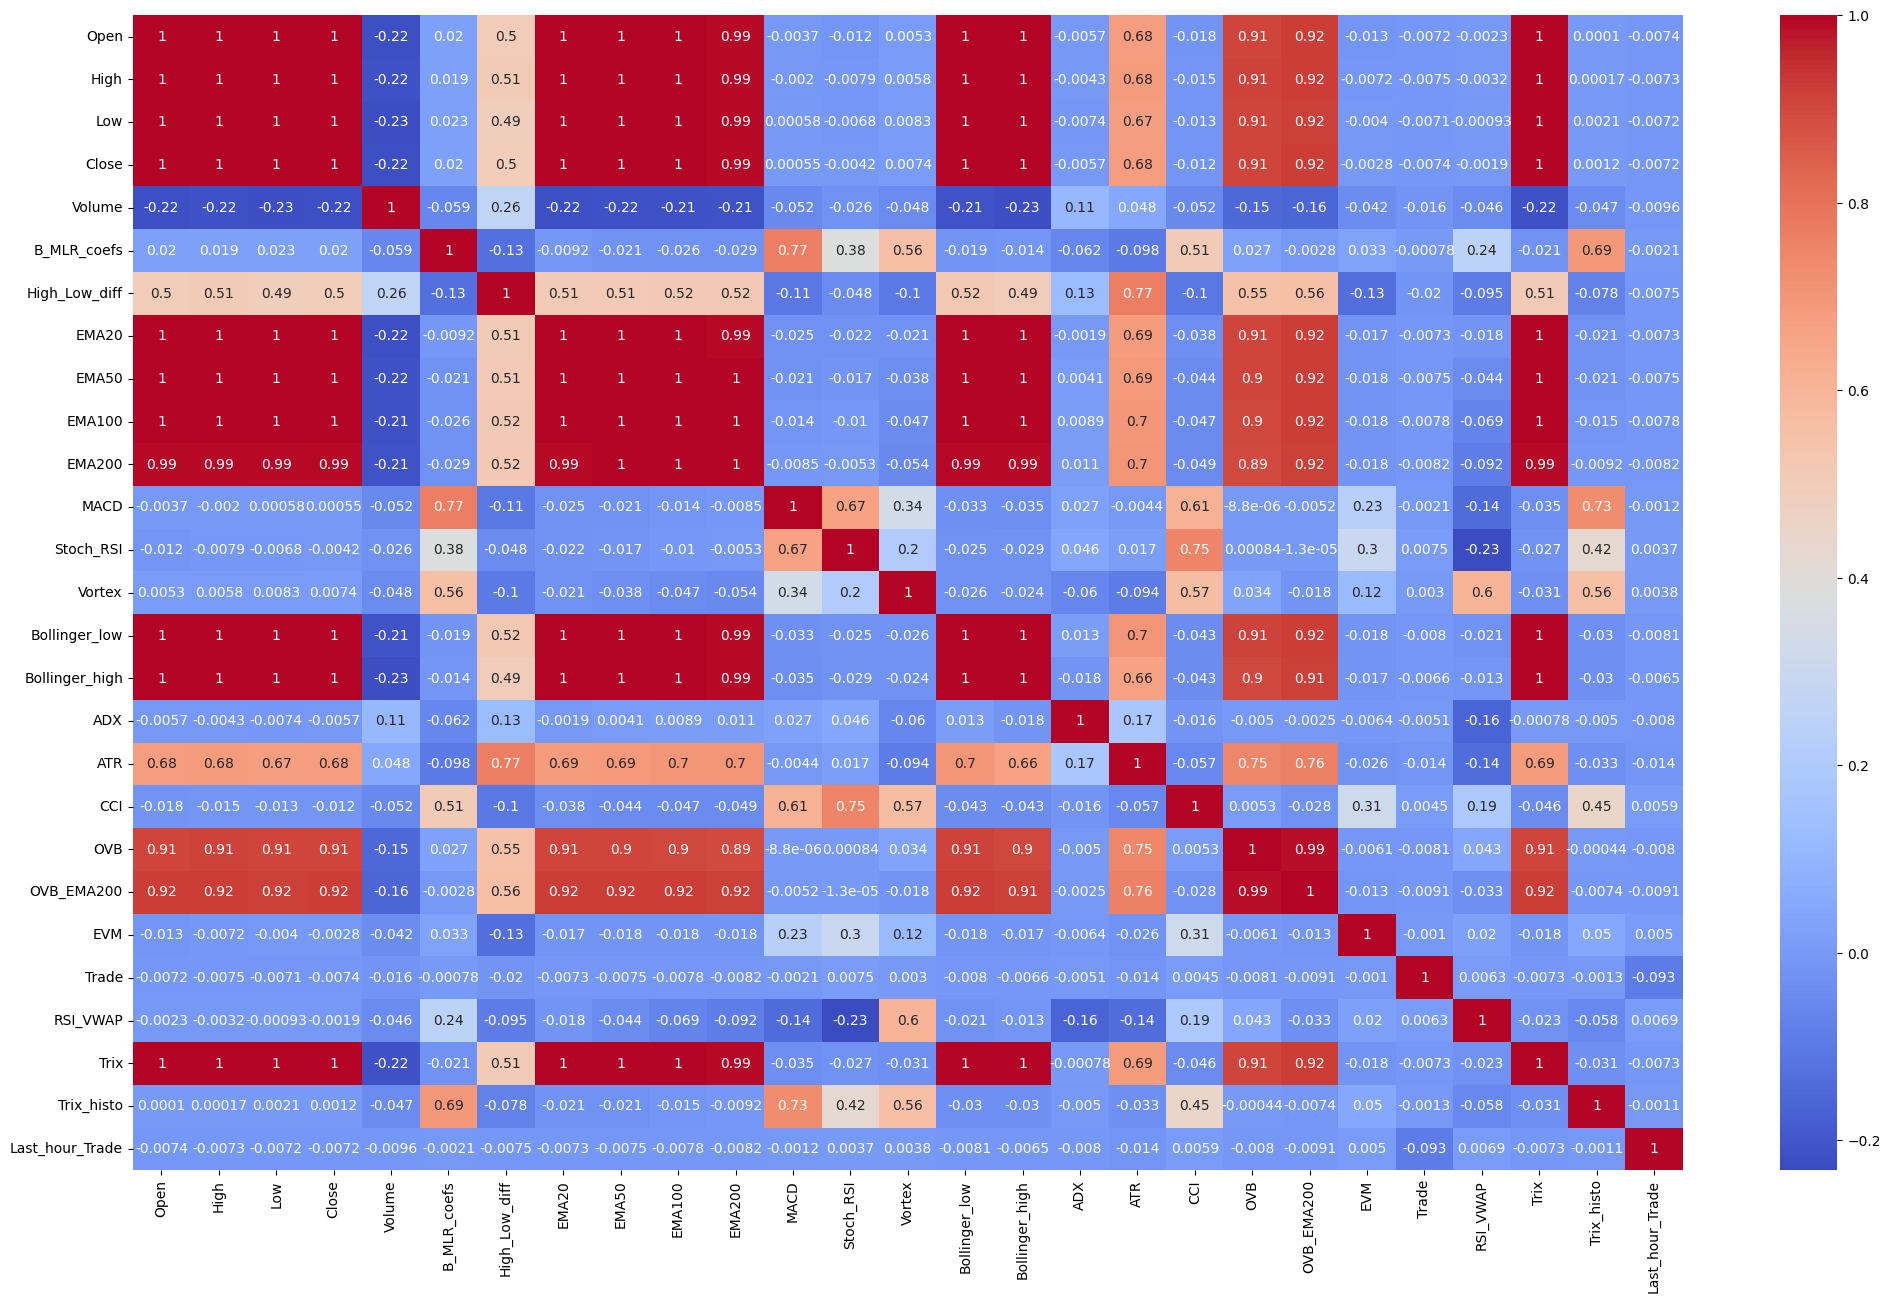

In [5]:
fig, ax = plt.subplots(1, figsize=(25,15))
import seaborn as sns

sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm',
        xticklabels=df_copy.columns,
        yticklabels=df_copy.columns,ax=ax)

### Imbalance handling 1

In [35]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df_copy[(df_copy['Trade']==0)] 
df_minority = df_copy[(df_copy['Trade']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_majority), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

### Imbalance handling 2

In [16]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_copy.drop('Trade', axis=1), df_copy['Trade'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

y = oversampled.Trade.values.reshape(-1,1)
X = oversampled.drop(columns=['Trade'])

y_2 = df.Trade.values.reshape(-1,1)
X_2 = df.drop(columns=['Trade'])

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
X_2 = feature_scaler.transform(X_2)

In [28]:
from sklearn.decomposition import PCA

decorrelator = PCA(n_components=12)
X_scaled = decorrelator.fit_transform(X_scaled)
X_2 = decorrelator.transform(X_2)

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

select = SelectKBest(score_func=f_classif, k='all')
z = select.fit_transform(X_scaled,y)
X_scaled=z

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,shuffle=True)

In [31]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((12,)))
model.add(Dense(units = 32,activation=keras.activations.relu))
model.add(Dense(units = 16,activation=keras.activations.relu))
model.add(Dropout(0.2))
model.add(Dense(units = 1,activation=keras.activations.sigmoid))

model.compile(optimizer = Adam(learning_rate=0.01), loss = 'binary_crossentropy',metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs=75,
          shuffle=True,
          batch_size=128,
          validation_split=0.2,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                        verbose=1,
                                                       patience=8,
                                                       min_delta=0.00005,
                                                       mode='max',
                                                       restore_best_weights=True)],
          use_multiprocessing=True)

print(f'Accuracy : {100*model.evaluate(X_test,y_test)[-1]:.1f} %')

2022-12-12 09:55:47.394696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 09:55:48.581334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 09:55:48.581377: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-12 09:55:48.694323: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-12 09:55:55.630275: W tensorflow/stream_executor/platform/de

Epoch 1/75
185/185 [==============================] - 8s 21ms/step - loss: 0.5853 - accuracy: 0.6876 - val_loss: 0.5303 - val_accuracy: 0.7306
Epoch 2/75
185/185 [==============================] - 3s 16ms/step - loss: 0.5329 - accuracy: 0.7304 - val_loss: 0.5213 - val_accuracy: 0.7353
Epoch 3/75
185/185 [==============================] - 3s 14ms/step - loss: 0.5155 - accuracy: 0.7395 - val_loss: 0.5035 - val_accuracy: 0.7504
Epoch 4/75
185/185 [==============================] - 3s 14ms/step - loss: 0.5021 - accuracy: 0.7514 - val_loss: 0.4976 - val_accuracy: 0.7533
Epoch 5/75
185/185 [==============================] - 3s 14ms/step - loss: 0.4950 - accuracy: 0.7535 - val_loss: 0.4937 - val_accuracy: 0.7468
Epoch 6/75
185/185 [==============================] - 3s 13ms/step - loss: 0.4902 - accuracy: 0.7563 - val_loss: 0.4907 - val_accuracy: 0.7587
Epoch 7/75
185/185 [==============================] - 3s 14ms/step - loss: 0.4864 - accuracy: 0.7590 - val_loss: 0.4819 - val_accuracy: 0.7653

# Optimization

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocess import cpu_count

results=[]

SYMBOL= 'BTC'
#df = loadFromDB(SYMBOL,'1h',True)
#df = df.iloc[-8000:]
#df = computeLaggingLinearRegression(df,window=25,filter_ceof=False, derivative=False,filter_method='savgol')
#df.dropna(inplace=True)

for window in range(5,50,3):
    #for polyorder in range(10,150,10):
        df = loadFromDB(SYMBOL,'1h',True)
        df = df.iloc[-8000:]
        df = computeLaggingLinearRegression(df,window=window,filter_ceof=False, derivative=False,filter_method='savgol')
        df.dropna(inplace=True)
        df_final = pd.DataFrame()

        def process_one_row(df_i):
            #fft_denoiser   
            #cycle, trend = hpfilter( df_i['EMA20'].values,polyorder) #trend
            df_i['B_MLR_coefs_denoised'] =savgol_filter(df_i.B_MLR_coefs.values, polyorder, 2, mode='nearest')#trend#explicit_heat_smooth(df_i.EMA20.values, 4)#polynomialRegression(df_i.Close.values,5,False)#filterData(df.EMA20.values,'hpf')#
            df_i['B_MLR_coefs_denoised_diff'] = df_i.B_MLR_coefs_denoised.diff(1)
            df.dropna(inplace=True)
            return df_i.iloc[-1]
            
        with ThreadPoolExecutor(max_workers=20) as executor:
            processes = [executor.submit(process_one_row, df.iloc[i-1500:i]) for i in range(1500,len(df))]

        for task in as_completed(processes):
            df_final = df_final.append(task.result())
            
        df_final.sort_index(inplace=True)

        #print('Testing strategy : ')
        def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
            return True if row.B_MLR_coefs_denoised_diff>0 else False

        def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
            return True if row.B_MLR_coefs_denoised_diff<0 else False
        #strategyTester(df_final,buyCondition,sellCondition,equity=1000, optimization_process=False)
        coins = strategyTester(df_final,buyCondition,sellCondition,equity=1000, optimization_process=True)
        result = {'window':window,'polyorder':polyorder,'coins':coins}
        print(result)
        results.append(result)

In [ ]:
result = []

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff<0 and row.B_MLR_coefs_filtered_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff>0 and row.B_MLR_coefs_filtered_diff<0 else False

for i in range(5,15, 1):
    df = computeLaggingLinearRegression(loadFromDB(SYMBOL).iloc[-10000:],
                                        window=i,filter_ceof=True, derivative=True,filter_method='savgol')
    equity = strategyTester(df.iloc[-7000:],buyCondition,sellCondition,optimization_process=True)
    print({'window':i,'balance':equity})
    result.append({'window':i,'balance':equity})

# Denoising

In [ ]:
import multiprocessing

model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0, n_jobs=multiprocessing.cpu_count())
model.fit(df.B_MLR_coefs.values.reshape(-1, 1),df.B_MLR_coefs_filtered.values)
model.score(df.B_MLR_coefs.values.reshape(-1, 1),df.B_MLR_coefs_filtered.values)

In [ ]:
len(df.B_MLR_coefs_filtered.values)

In [ ]:
WINDOW=20

X = np.array([df.B_MLR_coefs.iloc[i:i+WINDOW].values for i in range(len(df)-WINDOW)])
y = np.array([df.B_MLR_coefs_filtered.iloc[i:i+WINDOW].values for i in range(len(df)-WINDOW)])

fig, ax_left = plt.subplots(1, figsize=(25,8))

ind = 165
ax_left.plot(list(range(WINDOW)),X[ind], color='red',label='Raw')
ax_left.plot(list(range(WINDOW)),y[ind], color='blue',label='Denoised')
ax_left.legend(loc="upper left")

# Denoising autoencoder

In [ ]:
from keras.layers import Conv1D, Conv1DTranspose
from keras.models import Sequential
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
import multiprocessing

max_norm_value = 2.0
input_shape = (WINDOW,1 )


# Create the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='linear', padding='same'))

model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001,restore_best_weights=True,patience=4 ,verbose=1)

model.fit(X, y,
        epochs=5,
        batch_size=128,
        validation_split=0.3,
        use_multiprocessing=True,
        workers=multiprocessing.cpu_count(),
        callbacks=[es])


In [ ]:
fig, ax_left = plt.subplots(1, figsize=(25,8))

ind = 163
ax_left.plot(list(range(WINDOW)),X[ind], color='black',alpha=0.2,label='Raw')
ax_left.plot(list(range(WINDOW)),y[ind], color='blue',label='Denoised')
ax = ax_left.twinx()
ax.plot(list(range(WINDOW)),model.predict(X[ind].reshape(1,-1))[0].reshape(1,-1)[0], color='yellow',label='Prediction')
ax.plot(list(range(WINDOW)),savgol_filter(model.predict(X[ind].reshape(1,-1))[0].reshape(1,-1)[0], 10, 2, mode='nearest'), color='red',label='Filtered Prediction')

ax_left.legend(loc="upper left")
ax.legend(loc="upper right")

In [ ]:
import requests
response = requests.get(f'https://crypto-api.zlochteam.com/get-BTC-tweets').json()
print(f'{response["total"]} records in the dataset')

df_tweets = pd.DataFrame(response['data'])
df_tweets['Date'] = df_tweets['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tweets = df_tweets.set_index('Date')
df_tweets = df_tweets.sort_index(axis=0)
df_tweets.head()

response = requests.get(f'https://crypto-api.zlochteam.com/get-trading-view-indicators').json()
print(f'{response["total"]} records in the dataset')

df_tvta = pd.DataFrame(response['data'])
df_tvta['Date'] = df_tvta['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tvta = df_tvta.set_index('Date')
df_tvta = df_tvta.sort_index(axis=0)
df_tvta.head()

In [ ]:
df = df.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df_tweets = df_tweets.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df_tvta = df_tvta.loc[pd.to_datetime(df.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df.head()

In [ ]:
def generateHourlyDataFormTweets(tweet_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tweet_df['join_key'] = tweet_df.apply(createJoinKey, axis=1)
    tweet_df = tweet_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tweet_df['Date']=tweet_df.apply(recreateDates, axis=1)
    tweet_df = tweet_df.set_index('Date').sort_index(axis=0)
    return tweet_df.drop(columns=['join_key','timestamp'])
    
df_tweets = generateHourlyDataFormTweets(df_tweets)
df_tweets

In [ ]:
def generateHourlyDataFormTVTA(tvta_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tvta_df['join_key'] = tvta_df.apply(createJoinKey, axis=1)
    tvta_df = tvta_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tvta_df['Date']=tvta_df.apply(recreateDates, axis=1)
    tvta_df = tvta_df.set_index('Date').sort_index(axis=0)
    return tvta_df.drop(columns=['join_key','timestamp'])
    
df_tvta = generateHourlyDataFormTVTA(df_tvta)
df_tvta

# Kalman smoothing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import numpy as np

# Load the Apple stock price data into a pandas DataFrame
df = pd.read_csv('apple_stock_prices.csv', index_col='Date', parse_dates=True)

# Define the Kalman filter model
kf = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=df['Close'].iloc[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=.01)

# Use the Kalman filter to smooth the stock price data
smoothed_kalman = df['Close'].apply(lambda x: kf.filter(x)[0]).to_frame()

# Calculate the 50-period moving average of the stock price data
smoothed_ma = df['Close'].rolling(window=50).mean()

# Calculate MAE
mae = np.mean(np.abs(smoothed_kalman - smoothed_ma))

# Calculate RMSE
rmse = np.sqrt(np.mean((smoothed_kalman - smoothed_ma)**2))

# Print MAE and RMSE
print('MAE:', mae)
print('RMSE:', rmse)

# Create a new figure
plt.figure()

# Plot the original, Kalman-smoothed, and moving average-smoothed data
plt.plot(df['Close'], label='Original')
plt.plot(smoothed_kalman, label='Kalman-smoothed')
plt.plot(smoothed_ma, label='Moving average-smoothed')

# Plot the error between the Kalman-smoothed and moving average-smoothed data
plt.plot(mae, label='MAE_Error')
plt.plot(rmse, label='RMSE_Error')

# Add a legend
plt.legend()
import numpy as np
import pandas as pd

def initialize(context):
    # Set the asset to be traded
    context.asset = symbol('AAPL')
    
    # Set the number of days to hold the asset
    context.hold_days = 5
    
    # Set the window size for the Kalman filter and ZLEMA
    context.kalman_window = 30
    context.zlema_window = 10
    
    # Set the weight for the Kalman filter in the combination
    context.kalman_weight = 0.7
    
    # Initialize the Kalman filter
    context.kalman = KalmanFilter(dim_x=2, dim_z=1)
    context.kalman.x = np.array([[0], [0]])
    context.kalman.F = np.array([[1, 1], [0, 1]])
    context.kalman.H = np.array([[1, 0]])
    context.kalman.P *= 1000
    context.kalman.R = 5
    context.kalman.Q = Q_discrete_white_noise(2, 0.1, 1)

def handle_data(context, data):
    # Get the price history for the asset
    prices = data.history(context.asset, 'price', context.kalman_window, '1d')
    
    # Update the Kalman filter
    context.kalman.predict()
    context.kalman.update(prices[-1])
    
    # Calculate the ZLEMA
    zlema = (context.zlema_window - 1) * context.portfolio.positions[context.asset].cost_basis
    zlema += prices[-1]
    zlema /= context.zlema_window
    
    # Combine the Kalman filter and ZLEMA using the specified weight
    combined = context.kalman_weight * context.kalman.x[0] + (1 - context.kalman_weight) * zlema
    
    # If the price is above the combined value, buy the asset
    if data.can_trade(context.asset) and data.current(context.asset, 'price') > combined:
        order_target_percent(context.asset, 1.0)
    
    # If it's time to sell, sell the asset
    if context.hold_days > 0:
        context.hold_days -= 1
    else:
        order_target_percent(context.asset, 0)
        context.hold_days = 5